1 - Pour commencer

Questions

Quelles sont les sources de données textuelles pour le NLP ?
    Les données textuelles nécessaire pour le NLP peuvent se retrouver sur internet, via des bases de données textuelle existante (Wikipedia, Forum etc).

Pourquoi la collecte de données est-elle essentielle pour le NLP ?
    Les méthodes de NLP nécéssite de disposer d'une importante base de donnée, qui contient des éléments pertinent pour la finalité du NLP.

# Extraction de données à partir d'une API 
    API : NewsAPI
### 1 - Créer un compte API et récupérer une clé API (d23f0beac38543e58490208ac45957ae)
### 2 - Effectuer une requête pour collecter des articles sur un thème donné.
### 3 - Explorer les résultats obtenus, en identifiant sur les titres et les descriptions des articles.
### 4 - Sauvegarder les résulats dans un fichier CSV pour une utilisation ultérieure.

In [ ]:
import json
import csv
from requests import get
import os
from dotenv import load_dotenv
import pandas as pd
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer


Number of results: 37


In [ ]:
load_dotenv()

# Make the API request using the environment variable for the API key
api_key = os.getenv('NewsAPI_key')
if not api_key:
    raise ValueError("API key not found. Please set the 'NewsAPI_key' environment variable.")

apirequest = get(f"https://newsapi.org/v2/everything?q=covid19&from=2024-11-18&to=2024-12-18&sortBy=publishedAt&language=en&apiKey={api_key}")

# Check if the request was successful
if apirequest.status_code == 200:
    data = apirequest.json()
    
    # Check if 'articles' key exists in the response
    if 'articles' in data:
        # Open a CSV file for writing
        with open('api_response.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            
            # Write the header
            writer.writerow(['source', 'author', 'title', 'description', 'url', 'publishedAt', 'content'])
            
            # Write the data
            for article in data['articles']:
                writer.writerow([
                    article['source']['name'],
                    article.get('author', 'N/A'),
                    article['title'],
                    article['description'],
                    article['url'],
                    article['publishedAt'],
                    article.get('content', 'N/A')
                ])
    else:
        print("The key 'articles' was not found in the response.")
else:
    print(f"Failed to fetch data. HTTP Status code: {apirequest.status_code}")

# Display the number of results
num_results = len(data['articles'])
print(f"Number of results: {num_results}")

# Web scrapping de texte

## Choisir une source web adaptée (par exemple, un blog ou un site d’actualités)

### 1 — Identifier les balises HTML contenant les informations à extraire (par exemple, les titres des articles)
### 2 — Extraire les données textuelles et les afficher
### 3 — Enregistrer les données extraites dans un fichier CSV

In [ ]:
url = 'https://www.thelancet.com/collections/critical-care-other?parent=001548'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

articles = soup.find_all('input', class_='search_item_select')

data=[]
for idx, article in enumerate(articles, 1):
    title = article.text.strip()
    link = article['href']
    data.append([idx, title, link])

for item in data:
    print(f"{item[0]}: {item[1]} ({item[2]})")

with open('the_lancet.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Titre', 'Lien']) 
    writer.writerows(data)  

MissingSchema: Invalid URL 'YOUR_TARGET_URL_HERE': No scheme supplied. Perhaps you meant https://YOUR_TARGET_URL_HERE?

# TD 2 Nettoyage des Données Textuelles en Python pour le NLP

### — Identifier et supprimer les caractères spéciaux et hyperliens.
### — Convertir les textes en minuscules.
### — Supprimer les espaces inutiles et normaliser le format.

In [36]:
df = pd.read_csv('./api_response.csv')


def text_clean(text):
    if isinstance(text, str):
        # caps to lowercase
        text = text.lower()
        # del URLs
        text = re.sub(r'http[s]?://\S+', '', text) 
        # del non-letters
        text = re.sub(r'[^a-z\s]', '', text)
        # del useless spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
    return text

# clean columns 'title', 'description' and 'content'
df['title'] = df['title'].apply(text_clean)
df['description'] = df['description'].apply(text_clean)
df['content'] = df['content'].apply(text_clean)

# save the cleaned data
df.to_csv('articles_cleaned.csv', index=False)

# print the first 5 rows of  cleaned data
print(df.head())


              source                                             author  \
0  Project Syndicate                                     Kenneth Rogoff   
1   Freerepublic.com                                       Daily Signal   
2           Plos.org  Iheanyi Oby Nwaoha, Albain Ayime Balibuno, Nuh...   
3  Project Syndicate                                  Michael R. Strain   
4      Wordpress.com                                                NaN   

                                               title  \
0                 se hundir el segundo boom de trump   
1  exclusive what has hhs withheld on covid vax s...   
2  factors associated with the uptake and utilisa...   
3                            el populismo nunca dura   
4                       sam thursfield status update   

                                         description  \
0          project syndicate the worlds opinion page   
1  a new letter from sen ron johnson rwis puts fe...   
2  introduction diabetic retinopathy dr is a

### — Divisez les textes en unités lexicales (tokens) à l’aide d’une bibliothèque comme NLTK.
### — Effectuez une normalisation des mots (racine ou radical).
### — Comparez les résultats obtenus entre le stemming et la lemmatisation.

In [8]:
text = "Test, Test, ceci est un test."
tokens = word_tokenize(text)
print(tokens)

['Test', ',', 'Test', ',', 'ceci', 'est', 'un', 'test', '.']


In [ ]:
nltk.data.path.append('/Users/sh/nltk_data') 
nltk.download('punkt_tab', download_dir='/Users/sh/nltk_data')
nltk.download('wordnet', download_dir='/Users/sh/nltk_data')
nltk.download('stopwords', download_dir='/Users/sh/nltk_data')

# load csv
df = pd.read_csv('./articles_cleaned.csv')

# divide text into tokens
def tokenizer(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []

# stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# stemming
def apply_stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

# lemmatization
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# apply tokenizer, stemming, and lemmatization on text columns
df['title_tokens'] = df['title'].apply(tokenizer)
df['description_tokens'] = df['description'].apply(tokenizer)
df['content_tokens'] = df['content'].apply(tokenizer)

df['title_stemmed'] = df['title_tokens'].apply(apply_stemming)
df['description_stemmed'] = df['description_tokens'].apply(apply_stemming)
df['content_stemmed'] = df['content_tokens'].apply(apply_stemming)

df['title_lemmatized'] = df['title_tokens'].apply(apply_lemmatization)
df['description_lemmatized'] = df['description_tokens'].apply(apply_lemmatization)
df['content_lemmatized'] = df['content_tokens'].apply(apply_lemmatization)

stop_words = set(stopwords.words('english'))
print(stop_words)
# def stopwords
def del_sw(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# del stopwords from the columns
df['title_lemmatized_cleaned'] = df['title_lemmatized'].apply(del_sw)
df['description_lemmatized_cleaned'] = df['description_lemmatized'].apply(del_sw)
df['content_lemmatized_cleaned'] = df['content_lemmatized'].apply(del_sw)

# check
print(df[['title_lemmatized', 'title_lemmatized_cleaned']].head())

# save stemmed data
df[['title_stemmed', 'description_stemmed', 'content_stemmed']].to_csv('articles_stemmed.csv', index=False)

# save lemmatized data
df[['title_lemmatized', 'description_lemmatized', 'content_lemmatized']].to_csv('articles_lemmatized.csv', index=False)

df_cleaned = df[['source', 'author', 'title_lemmatized_cleaned', 'description_lemmatized_cleaned', 'content_lemmatized_cleaned']]
df_cleaned.to_csv('./articles_lemmatized_cleaned.csv', index=False)

print(df.head())

{'whom', 'or', 'hadn', 'most', 'more', 'themselves', 'but', 'then', 'hasn', 'a', 'd', "you've", 'no', 'weren', 'up', 'shouldn', "you're", "she's", 'some', 'they', "haven't", 'were', 'out', 'didn', 'needn', 'above', 'just', 'hers', 'how', 'am', 'this', 'now', 'not', 'if', 'll', 'ours', 'wasn', 'm', 'mustn', 'as', 'he', 'are', 'all', 'having', 'between', 'mightn', 'myself', 'will', 'there', "hadn't", 'against', 'of', 'down', "weren't", 'before', 'don', 'below', "couldn't", 'y', 've', 'after', 'again', 'ain', 'your', 'their', 'won', "should've", 'same', 'be', 'these', 'when', 'she', 'should', 'that', 'himself', 'being', 'o', 'shan', 'yours', 'haven', 'does', 'while', 'why', 't', 'only', "isn't", 'him', 'her', 'those', 'is', 'it', 'yourselves', "you'll", 'yourself', 'isn', 'my', "shan't", 'during', 'with', 'such', 'you', "needn't", 'off', 'his', 'on', 'because', 'own', 'do', 'very', 'in', 'where', 'we', "you'd", 'itself', 'each', 'further', "don't", 'them', 'an', 'for', 'through', 'aren', 

[nltk_data] Downloading package punkt_tab to /Users/sh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TD 3 : Analyse des Données Textuelles en Python pour le NLP

### — Explorer des méthodes d’analyse des données textuelles.
### — Visualiser des informations clés (fréquences, nuages de mots).
### — Utiliser des outils pour effectuer une analyse de sentiment.

## Dans cette section, nous allons explorer les données textuelles nettoyées pour en extraire des informations clés comme les fréquences de mots.

Chargement des données

In [40]:
al = pd.read_csv('./articles_lemmatized_cleaned.csv')

Fusion des colonnes

In [42]:
# Combine columns in one
al['combined_text'] = al['title_lemmatized_cleaned'].astype(str) + " " + al['description_lemmatized_cleaned'].astype(str) + " " + al['content_lemmatized_cleaned'].astype(str)

# Combine texts
corpus = " ".join(al['combined_text'])

# Check
print(corpus[:500]) 

['exclusive', 'ha', 'hhs', 'withheld', 'covid', 'vax', 'sen', 'ron', 'johnson', 'find'] ['new', 'letter', 'sen', 'ron', 'johnson', 'rwis', 'put', 'federal', 'health', 'agency', 'notice', 'plan', 'subpoena', 'unredacted', 'record', 'withheld', 'biden', 'administration', 'potential', 'adverse', 'effect', 'covid', 'vaccine', 'appears', 'even', 'waning', 'day'] ['skip', 'comment', 'exclusive', 'ha', 'hhs', 'withheld', 'covid', 'vax', 'sen', 'ron', 'johnson', 'find', 'outdaily', 'signal', 'december',


Mots les plus communs

In [43]:
# Divide text into words
words = corpus.split()

# Count the frequency of each word
word_freq = Counter(words)

# Extract the 20 most common words
most_common_words = word_freq.most_common(20)  # Les 20 mots les plus fréquents
print(most_common_words)


[("'char']", 33), ("'covid',", 30), ("'ha',", 14), ("'pandemic',", 14), ("'trump',", 11), ("'time',", 10), ("'new',", 10), ("'health',", 9), ("'comment',", 9), ("'hut',", 9), ("'vaccine',", 8), ("'one',", 8), ("'healthcare',", 8), ("['skip',", 7), ("'research',", 7), ("'wa',", 7), ("'make',", 7), ("'posted',", 6), ("'cohort',", 6), ("'muscle',", 6)]


Visualisation

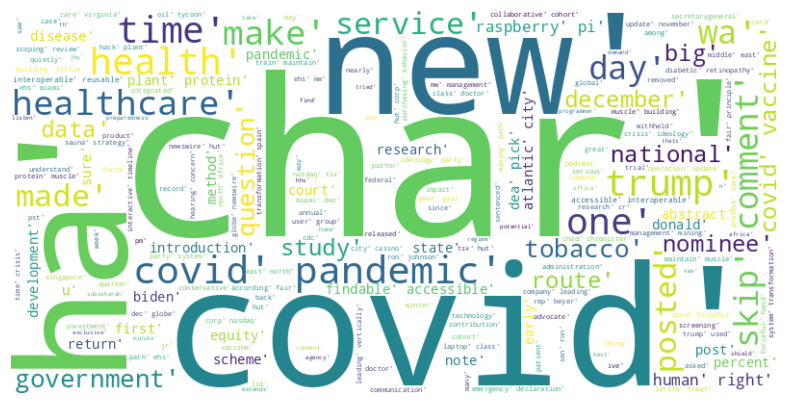

In [44]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Analyse statistique

In [45]:
# Tot num words
total_words = len(words)

# Average lenght
avg_word_length = sum(len(word) for word in words) / total_words

# Unique words
unique_words = len(set(words))

print(f"Nombre total de mots : {total_words}")
print(f"Longueur moyenne des mots : {avg_word_length:.2f}")
print(f"Nombre de mots uniques : {unique_words}")


Nombre total de mots : 1696
Longueur moyenne des mots : 9.34
Nombre de mots uniques : 892


Graphique de fréquence

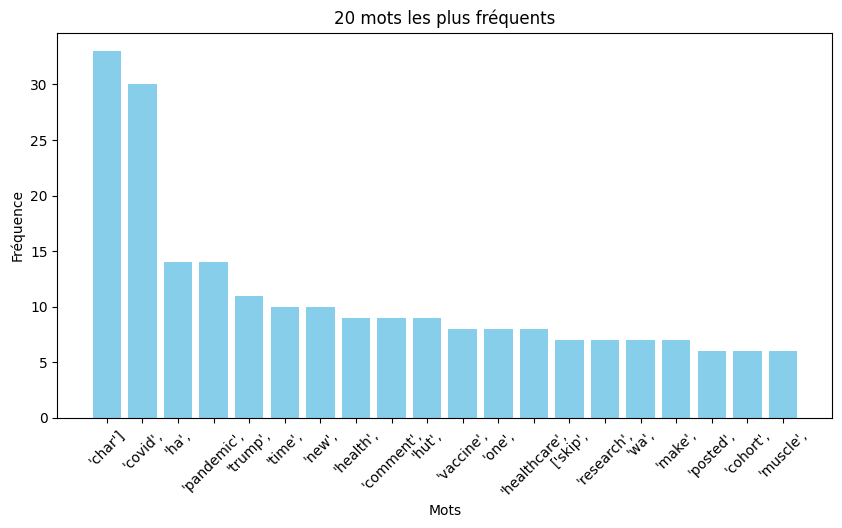

In [46]:
common_words, counts = zip(*most_common_words)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(common_words, counts, color='skyblue')
plt.title("20 mots les plus fréquents")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.xticks(rotation=45)
plt.show()

Analyse de sentiments

#### — Appliquer une fonction d’analyse de sentiment sur les textes nettoyés pour obtenir un score de polarité.
#### — Visualiser la distribution des scores de sentiment à l’aide d’un histogramme.
#### — Comparer les résultats obtenus avec des exemples concrets pour valider les interprétations.

Test de TextBlob

In [89]:

test_text = "leonie is very bad at coding i hate her!"
blob = TextBlob(test_text)
sentiment = blob.sentiment

print(f"Polarité: {sentiment.polarity}")
print(f"Subjectivité: {sentiment.subjectivity}")


Polarité: -0.9549999999999998
Subjectivité: 0.8833333333333333


Chargement données

In [82]:
al = pd.read_csv('./articles_lemmatized_cleaned.csv')

# Analyser le sentiment global du texte
text = " ".join(al['title_lemmatized_cleaned'].astype(str)) + " " + " ".join(al['description_lemmatized_cleaned'].astype(str)) + " " + " ".join(al['content_lemmatized_cleaned'].astype(str))
text_blob = TextBlob(text)

print(text)

print(f"Polarité: {text_blob.sentiment.polarity}")  # [-1, 1]
print(f"Subjectivité: {text_blob.sentiment.subjectivity}")  # [0, 1]


['exclusive', 'ha', 'hhs', 'withheld', 'covid', 'vax', 'sen', 'ron', 'johnson', 'find'] ['factor', 'associated', 'uptake', 'utilisation', 'diabetic', 'retinopathy', 'screening', 'service', 'subsaharan', 'africa', 'scoping', 'review'] ['sam', 'thursfield', 'status', 'update'] ['new', 'phsvp', 'collaborative', 'cohort', 'cohort', 'covid', 'research', 'cr', 'jackson', 'heart', 'study', 'jhs'] ['biden', 'regime', 'quietly', 'extends', 'covid', 'emergency', 'declaration', 'shield', 'big', 'pharma', 'mrna', 'vaccine', 'maker', 'liability'] ['hack', 'plant', 'protein', 'muscle', 'building', 'little', 'train', 'maintain', 'muscle', 'sauna', 'strategy', 'best', 'time', 'take', 'melatonin', 'solosode'] ['time', 'crisis', 'ideology', 'party', 'system', 'transformation', 'spain'] ['computer', 'programmer', 'quit', 'company', 'tried', 'force', 'work', 'office', 'rather', 'home', 'ceo', 'asked', 'come', 'back', 'serious', 'demand'] ['mother', 'injured', 'covid', 'vaccine', 'trial', 'mission', 'help'

In [106]:
from textblob import TextBlob

# créer segment
def segment_tokens(tokens, group_size=9):
    return [tokens[i:i + group_size] for i in range(0, len(tokens), group_size)]

# analyser sentiment
def analyze_sentiment_for_groups(tokens):
    # Segmenter tokens group 9
    segments = segment_tokens(tokens, 9)
    
    # Analyser polarité et la subjectivité 
    sentiments = []
    for segment in segments:
        text = " ".join(segment) 
        blob = TextBlob(text) 
        sentiment = blob.sentiment
        sentiments.append({
            'group': segment, 
            'polarity': sentiment.polarity,  
            'subjectivity': sentiment.subjectivity 
        })
    
    return sentiments


tokens = text.split()

# Analyse
sentiments = analyze_sentiment_for_groups(tokens)

# Afficher  résultats
for sentiment in sentiments:
    print(f"Groupe: {' '.join(sentiment['group'])}")
    print(f"Polarité: {sentiment['polarity']}, Subjectivité: {sentiment['subjectivity']}\n")


Groupe: ['exclusive', 'ha', 'hhs', 'withheld', 'covid', 'vax', 'sen', 'ron', 'johnson',
Polarité: 0.0, Subjectivité: 0.0

Groupe: 'find'] ['factor', 'associated', 'uptake', 'utilisation', 'diabetic', 'retinopathy', 'screening', 'service',
Polarité: 0.0, Subjectivité: 0.0

Groupe: 'subsaharan', 'africa', 'scoping', 'review'] ['sam', 'thursfield', 'status', 'update'] ['new',
Polarité: 0.13636363636363635, Subjectivité: 0.45454545454545453

Groupe: 'phsvp', 'collaborative', 'cohort', 'cohort', 'covid', 'research', 'cr', 'jackson', 'heart',
Polarité: 0.0, Subjectivité: 0.0

Groupe: 'study', 'jhs'] ['biden', 'regime', 'quietly', 'extends', 'covid', 'emergency', 'declaration',
Polarité: 0.0, Subjectivité: 0.3333333333333333

Groupe: 'shield', 'big', 'pharma', 'mrna', 'vaccine', 'maker', 'liability'] ['hack', 'plant',
Polarité: 0.0, Subjectivité: 0.1

Groupe: 'protein', 'muscle', 'building', 'little', 'train', 'maintain', 'muscle', 'sauna', 'strategy',
Polarité: -0.1875, Subjectivité: 0.5

Gr